# Dreidel Simulations

Since the game of dreidel is completely deterministic, I wanted to see if I can find any aspect about it's probability that can make it more interesting. So, I decided to try to answer the question, given the set up of a particular game, what's the distribution of total amount I'm going to walk away with?  

The rules work as follows:

There are a total number of T players playing, each starting out with the same N number of tokens/coins/etc. Initially, eah player antes one "token" into the pot. In each round the players take turns spinning a dreidel, which has four different outcomes (corresponding to four Hebrew letters):
* "Nun" - nothing happens and play continues to the next person
* "Gimmel" - the player gets all of the tokens in the pot
* "Hey" - the player gets half of the tokens in the pot (for this purpose, I rounded down in case of odd totals)
* "Shin" - the player loses a token and puts it in the pot

If at any point, the pot becomes empty, each player is required to, once again, "ante up." 

Play continues for any length of rounds...or until people simply want to quit. 

I don't recall the "official" rule (not like there's any sort of official governing body of dreidel-playing...), but for purposes of these simulations, if at any point a player is in a situation where he goes into a negative total (like 0 left and must ante or gets a "Shin") than he is eliminated.

In [129]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline
import collections
import seaborn as sns
from fitter import Fitter
from scipy.stats import normaltest

In [122]:
def dreidel(player_num, player_total, per_player, rounds, sims):
    """Takes in the turn number a given player takes, total number playing,
    total number of tokens each player starts with, total rounds to be played and
    number of games simulated.
    
    Returns the total number of tokens (plus the player's share of the pot) that a given player has
    across all simulations"""
    
    tot = []
    
    for game in range(sims):
        
        scorecard={i+1:per_player-1 for i in range(player_total)}
        removed=[]
        pot=player_total
        
        for round_ in range(rounds):
            
            for player in sorted(scorecard.keys()):
                
                try:
                    spin=random.choice(['nun','gimmel','hey','shin'])        
                
                    if spin=='nun':
                        continue
                    elif spin=='gimmel':
                        scorecard[player]+=pot
                        pot=0
                    elif spin=='hey':
                        scorecard[player]+=pot/2
                        pot-=pot/2
                    elif spin=='shin':
                        if scorecard[player]>0:
                            scorecard[player]-=1
                            pot+=1
                        else:
                            del scorecard[player]
                            removed.append(player)

                    if pot == 0:
                        for person in scorecard.keys():
                            scorecard[person]-=1
                            if scorecard[person]<0:
                                del scorecard[person]
                                removed.append(person)
                        pot += len(scorecard.keys())

                    assert pot+sum(scorecard.values())==per_player*player_total
                except:
                    continue
                
        if player_num in removed:
            
            tot.append(0)
        else:
            tot.append(scorecard[player_num]+pot/len(scorecard))# note that if there are leftover tokens in the pot, 
                                                                # they are divided evenly by the remaining players. 
                                                                # If they cannot be evenly divided, they are simply 'thrown out,'
                                                                # which leaves a funny design quirk
            
            
    return tot   

In [90]:
game1 = dreidel(1,5,25,50,1000)

Let's visualize one set of 1000 games. As a baseline, we'll choose the first player among 5, starting with 25 after the 50th round. 

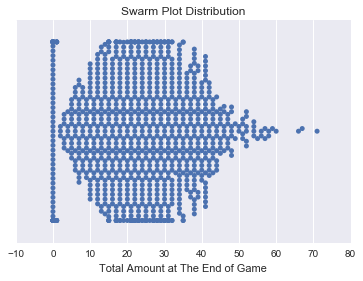

In [91]:
sns.swarmplot(game1)
plt.xlabel("Total Amount at The End of Game")
plt.title("Swarm Plot Distribution")

In [92]:
np.mean(game1)

23.994

In [116]:
np.median(game1)

24.0

The heavy tail at 0 is due to the fact that, whenever a player's totl crosses into negative territory, he's eliminated. So, there are plenty bunched up at the bottom.

Now, let's see what happens when we have someone play with a much larger group, 20:

In [105]:
game2 = dreidel(1,20,25,50,1000)

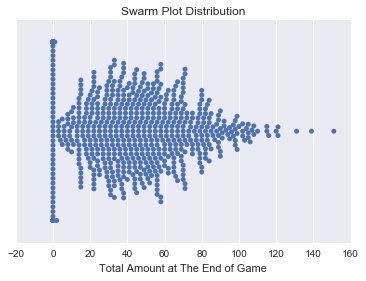

In [106]:
sns.swarmplot(game2)
plt.xlabel("Total Amount at The End of Game")
plt.title("Swarm Plot Distribution")

In [107]:
np.mean(game2)

29.216000000000001

In [115]:
np.median(game2)

22.0

The mean clearly increases to several tokens above the starting point. This is likely due to the fact that going first gives a distinct advantage to going later on. 
However, one quirk to the way I designed this has the leftover tokens "thrown out" if not evenly divisible by the remaining players. That's likely why this player loses in his median value.

Let's see what happens when the player goes last among 20:

In [108]:
game3 = dreidel(20,20,25,50,1000)

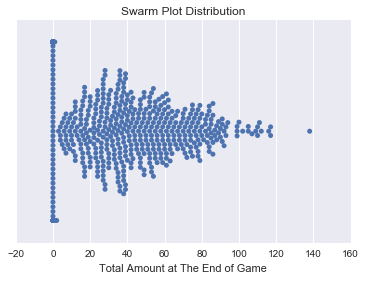

In [109]:
sns.swarmplot(game3)
plt.xlabel("Total Amount at The End of Game")
plt.title("Swarm Plot Distribution")

In [112]:
np.mean(game3)

21.41

In [114]:
np.median(game3)

0.0

This last player is at a heavy disadvantage, presumably because the previous players had more opportunities to gain token before he did.

Now let's use the fitter api to find the best distribution:

In [118]:
f = Fitter(game1)

In [119]:
f.fit()

Fitted alpha distribution with error=0.0204239479124)
Fitted anglit distribution with error=0.0239715625994)
Fitted arcsine distribution with error=0.0328598952697)
Fitted beta distribution with error=0.0202835410477)
Fitted betaprime distribution with error=0.0201478663013)
Fitted bradford distribution with error=0.0260567669199)
Fitted burr distribution with error=0.0358071096412)
Fitted burr12 distribution with error=0.0614088408639)
Fitted cauchy distribution with error=0.0226851864637)
Fitted chi distribution with error=0.086059638003)
Fitted chi2 distribution with error=0.0315421011527)
Fitted cosine distribution with error=0.0212707648297)
Fitted dgamma distribution with error=0.0201202666862)
Fitted dweibull distribution with error=0.0206027308668)
Fitted erlang distribution with error=0.020156517822)
Fitted expon distribution with error=0.0284574541934)
Fitted exponnorm distribution with error=0.0200910486426)
Fitted exponpow distribution with error=0.0555686050813)
Fitted exp

,sumsquare_error
gompertz,0.019606
gennorm,0.019954
rdist,0.019965
tukeylambda,0.019972
loggamma,0.020006


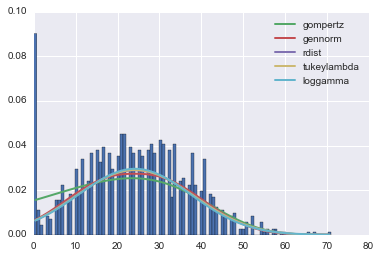

In [120]:
f.summary()

In [123]:
f.fitted_param['gompertz']

(0.30233123322754862, -0.00024780826497108758, 19.632288426465269)

Using the fitter library, I just iterated through all of scipy's continuous ditributions looking for best fit. It returned, 'gompertz' together with it's parameters. Nothing about the parameters seems intuitive about the way I set up the game.

Presumably, the best fit would be careful variation of a discreet distribution. What likely throws this off os the fact that a player can get eliminated when at 0. If I tweaked the rules to allow negative values, the distribution would probably be more intuitive. Let's see what happens:

In [124]:
def dreidel_alt(player_num, player_total, per_player, rounds, sims):
    """Takes in the turn number a given player takes, total number playing,
    total number of tokens each player starts with, total rounds to be played and
    number of games simulated.
    
    Returns the total number of tokens (plus the player's share of the pot) that a given player has
    across all simulations"""
    
    tot = []
    
    for game in range(sims):
        
        scorecard={i+1:per_player-1 for i in range(player_total)}
        pot=player_total
        
        for round_ in range(rounds):
            
            for player in sorted(scorecard.keys()):
                
                try:
                    spin=random.choice(['nun','gimmel','hey','shin'])        
                
                    if spin=='nun':
                        continue
                    elif spin=='gimmel':
                        scorecard[player]+=pot
                        pot=0
                    elif spin=='hey':
                        scorecard[player]+=pot/2
                        pot-=pot/2
                    elif spin=='shin':
                        scorecard[player]-=1
                        pot+=1

                    if pot == 0:
                        for person in scorecard.keys():
                            scorecard[person]-=1
                        pot += len(scorecard.keys())

                    assert pot+sum(scorecard.values())==per_player*player_total
                except:
                    continue
                
    
        tot.append(scorecard[player_num]+pot/len(scorecard))# note that if there are leftover tokens in the pot, 
                                                                # they are divided evenly by the remaining players. 
                                                                # If they cannot be evenly divided, they are simply 'thrown out,'
                                                                # which leaves a funny design quirk
            
            
    return tot   

In [131]:
alt_game = dreidel_alt(1,5,25,50,1000)

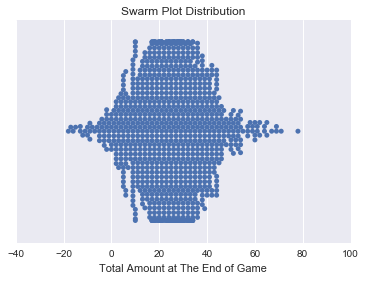

In [132]:
sns.swarmplot(alt_game)
plt.xlabel("Total Amount at The End of Game")
plt.title("Swarm Plot Distribution")

In [133]:
np.mean(alt_game)

24.989999999999998

In [134]:
np.median(alt_game)

25.0

In [137]:
f2 = Fitter(alt_game)

In [138]:
f2.fit()

Fitted alpha distribution with error=0.00198918092796)
Fitted anglit distribution with error=0.00596139986967)
Fitted arcsine distribution with error=0.021762281143)


/Users/moshelaster/anaconda/lib/python2.7/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Fitted beta distribution with error=0.00177910526993)
Fitted betaprime distribution with error=0.00212485163626)
Fitted bradford distribution with error=0.012106010324)
Fitted burr distribution with error=0.0651253404399)


/Users/moshelaster/anaconda/lib/python2.7/site-packages/scipy/stats/_continuous_distns.py:716: RuntimeWarning: overflow encountered in power
  return log(c) + log(d) + special.xlogy(c-1, x) + special.xlog1py(-d-1, x**c)


Fitted burr12 distribution with error=0.0201370879393)
Fitted cauchy distribution with error=0.00313268170876)
Fitted chi distribution with error=0.0230256084764)
Fitted chi2 distribution with error=0.157797932074)
Fitted cosine distribution with error=0.00380391397015)
Fitted dgamma distribution with error=0.00230197229549)
Fitted dweibull distribution with error=0.00201857583978)


/Users/moshelaster/anaconda/lib/python2.7/site-packages/scipy/stats/_continuous_distns.py:2098: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 344.40000000000003.
  RuntimeWarning)
/Users/moshelaster/anaconda/lib/python2.7/site-packages/scipy/stats/_continuous_distns.py:2098: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 311.59999999999997.
  RuntimeWarning)
/Users/moshelaster/anaconda/lib/python2.7/site-packages/scipy/stats/_continuous_distns.py:2098: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 317.06666666666661.
  RuntimeWarning)
/Users/moshelaster/anaconda/lib/python2.7/site-packages/scipy/stats/_continuous_distns.py:2098: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 325.26666666666665.
  RuntimeWarning)
/Users/moshelaster/anaconda/lib/python2.7/site-packages/scipy/stats/_con

Fitted erlang distribution with error=0.00177927697147)
Fitted expon distribution with error=0.0157730824392)
Fitted exponnorm distribution with error=0.00176505659892)
Fitted exponpow distribution with error=0.0362411070932)


/Users/moshelaster/anaconda/lib/python2.7/site-packages/scipy/stats/_continuous_distns.py:1226: RuntimeWarning: invalid value encountered in add
  negxc + special.xlogy(c - 1.0, x))


Fitted exponweib distribution with error=0.06985729986)
Fitted f distribution with error=0.0795510684624)
Fitted fatiguelife distribution with error=0.00177914071849)
Fitted fisk distribution with error=0.087249159739)
Fitted foldcauchy distribution with error=0.242697789329)
Fitted foldnorm distribution with error=0.00177500415728)
Fitted frechet_l distribution with error=0.0554269818842)
Fitted frechet_r distribution with error=0.0566975634457)
Fitted gamma distribution with error=0.00177988643968)
Fitted gausshyper distribution with error=0.00218312224133)
Fitted genexpon distribution with error=0.013519519598)
Fitted genextreme distribution with error=0.00193022998666)
Fitted gengamma distribution with error=0.059694699839)
Fitted genhalflogistic distribution with error=0.00825226371829)
Fitted genlogistic distribution with error=0.00177932921045)
Fitted gennorm distribution with error=0.00174243561041)
Fitted genpareto distribution with error=0.0110870334377)
Fitted gilbrat distri

/Users/moshelaster/anaconda/lib/python2.7/site-packages/scipy/stats/_continuous_distns.py:4319: RuntimeWarning: divide by zero encountered in power
  return np.power((1.0 - x**2), c / 2.0 - 1) / special.beta(0.5, c / 2.0)


Fitted rdist distribution with error=0.0133261652074)
Fitted recipinvgauss distribution with error=0.0296001508616)
Fitted reciprocal distribution with error=2.2903066822)
Fitted rice distribution with error=0.00178548713474)
SKIPPED rv_continuous distribution (taking more than 30 seconds)
Fitted semicircular distribution with error=0.00832302529827)
Fitted skewnorm distribution with error=0.00177594847216)
Fitted t distribution with error=0.00173861952385)
Fitted trapz distribution with error=0.015347651742)
Fitted triang distribution with error=0.00402616226762)
Fitted truncexpon distribution with error=0.0119949570818)
Fitted truncnorm distribution with error=2.40912109083)
Fitted tukeylambda distribution with error=0.00173942778772)
Fitted uniform distribution with error=0.0118012152778)
Fitted vonmises distribution with error=1.10018470834e+58)
Fitted vonmises_line distribution with error=0.00174228277441)
Fitted wald distribution with error=0.0107950918534)
Fitted weibull_max dis

,sumsquare_error
t,0.001739
tukeylambda,0.001739
vonmises_line,0.001742
johnsonsu,0.001742
gennorm,0.001742


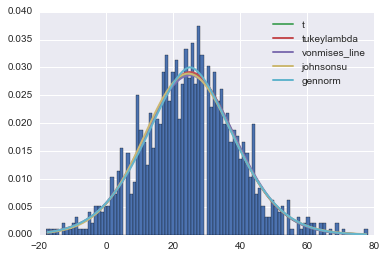

In [139]:
f2.summary()

In [149]:
f2.df_errors.loc['norm']

sumsquare_error    0.001775
Name: norm, dtype: float64

Though it fit other distributions slightly better, it also seemed to fit a regular normal distribution. This seems to show that a much of the complexity comes down to the "eliminated at 0" rule.